In [49]:
#keras_timeseries.py
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten    
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#from keras.layers.convolutional import Convolution2D
#from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from keras import backend as K

df = pd.read_csv("data-1000customers.csv")
#df = pd.read_csv("100_timeseries_checking_to_share.csv")
#print (df.columns.values)
#df = df.iloc[:,0:3]
#use column names
df = df[['client_debtor_number','dates','fv_cost']]
#print("new dataset columns ",df.columns.values)
#df.head()
# number of customers
len(df['client_debtor_number'].unique())

/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1000

In [3]:

def lag_feature(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['fv_cost'])
    
    def rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.fv_cost.shift(i).pipe(rename_lag, i))

    df.dropna(inplace=True)
    return df


def prepare_training_data(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cost_vals = scaler.fit_transform(series_data.values.reshape(-1, 1))
    
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

In [4]:
# 3 lags for each data point as input to model
lag =  3

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

#add convolution layer

#Convolution2D (https://keras.io/layers/convolutional/) expects the input to be in the format (samples, rows, cols, channels), 
#which is "channels-last". data is in the format (samples, channels, rows, cols). You should be able to fix
#this using the optional keyword data_format = 'channels_first' when declaring the Convolution2D layer else use
# input_shape=(3,1).
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
#model.add(Flatten()) # as flatten is converting data into 1D but we need 3D for our 3lags data here

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))
# we can add dropoutlayer after dense as well again
model.add(Dropout(0.2))
# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [20]:
df_cust = df[df['client_debtor_number'] == 1009141]
df_cust.head()
train_cs = df_cust[df_cust['dates'].str.contains('/2018') == False]
test_cs = df_cust[df_cust['dates'].str.contains('/2018') == True]

print (train_cs.tail())
print (test_cs.tail())
print (train_cs.describe())
np.isnan(train_cs.any())
print ("data length",len(df_cust))

#train_x_cs,train_y_cs, scaler = prepare_training_data(train_cs['fv_cost'], 3)
#test_x_cs,test_y_cs,scalar = prepare_training_data(test_cs['fv_cost'], 3)
#print(train_x_cs.shape)
#print(train_y_cs.shape)
#model.fit(train_x_cs, train_y_cs, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    


        client_debtor_number       dates  fv_cost
995965               1009141  12/07/2017      0.0
995966               1009141  13/07/2017      0.0
995967               1009141  14/07/2017      0.0
995968               1009141  15/07/2017      0.0
995969               1009141  16/07/2017      0.0
        client_debtor_number       dates  fv_cost
995985               1009141  16/08/2018      0.0
995986               1009141  17/08/2018      0.0
995987               1009141  18/08/2018      0.0
995988               1009141  19/08/2018      0.0
995989               1009141  20/08/2018      0.0
       client_debtor_number     fv_cost
count                 702.0  700.000000
mean              1009141.0   -0.336823
std                     0.0    1.181062
min               1009141.0   -6.118121
25%               1009141.0    0.000000
50%               1009141.0    0.000000
75%               1009141.0    0.000000
max               1009141.0    3.173864
data length 1120


In [42]:
# remove customer 1009141 as 200 rows of this cutomer row values has been moved left
# dates column has been replaced with other unusual values
#df = df[df.client_debtor_number != 1009141] #1010055

#find rows which has fv_cost nulls
#df= df[pd.isnull(df['fv_cost'])]
#df =
df1 = df[df.fv_cost.notnull()]
print ("number of null rows",df['fv_cost'].isnull().sum())
print ("length of dataframe",len(df))
print ("percentage of null values",((df['fv_cost'].isnull().sum())/(len(df)))*100)
df_null = df[df['fv_cost'].isnull()]
print ("number of customers having null values",len(df_null['client_debtor_number'].unique()))
print ("number of not null", len(df1))
len(df1['client_debtor_number'].unique())

number of null rows 194199
length of dataframe 1048575
percentage of null values 18.520277519490737
number of customers having null values 1000
number of not null 854376


1000

Model for each customer series and prediction in the same loop

In [131]:
%%time
i=0
train_rmse =[]
test_rmse = []
actual_train_rmse = []
actual_error_scores_test = list()
for cust_id, cust_data in df1.groupby('client_debtor_number'):
    print ("customer number ",i)
    i=i+1
    train_x = cust_data[cust_data['dates'].str.contains('/2018') == False]
    test_x = cust_data[cust_data['dates'].str.contains('/2018') == True]
    train_x_cust,train_y_cust, scalar_train = prepare_training_data(train_x['fv_cost'], 3)
    test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_x['fv_cost'], 3)  
    model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    # input size should be divisible by batch size for stateful LSTM
    trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
    #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
    #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    #print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
    train_rmse.append(trainScore)
    test_rmse.append(testScore)
    # generate predictions for training
    trainPredict = model.predict(train_x_cust,batch_size=1)
    testPredict = model.predict(test_x_cust,batch_size=1)
    yhat_act_test = scalar_test.inverse_transform(testPredict)
    # report performance
    rmse_test = sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act_test)):], yhat_act_test))
    print(cust_id," Test RMSE: ",rmse_test)
    actual_error_scores_test.append(rmse_test)
    yhat_act_train = scalar_train.inverse_transform(trainScore)
    rmse_train = sqrt(mean_squared_error(train_x.fv_cost[-(len(yhat_act_train)):],yhat_act_train))
    actual_train_rmse.append(rmse_train)
    # write predictions into csv
    result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
    #result_prediction['dates'] = test_x['dates']
    result_prediction['original_fv_scaled'] = test_y_cust
    result_prediction['prediction_scaled'] = testPredict
    result_prediction['prediction_actual'] = yhat_act_test
    result_prediction['fv_actual'] = test_x.fv_cost[-(len(yhat_act_test)):]
    result_prediction.to_csv("predictions_1000_customers/predictions_for_client_"+str(cust_id)+".csv")
    model.reset_states()

customer number  0
Epoch 1/10
 - 5s - loss: 0.0018
Epoch 2/10
 - 5s - loss: 7.3911e-04
Epoch 3/10
 - 5s - loss: 7.9685e-04
Epoch 4/10
 - 5s - loss: 0.0012
Epoch 5/10
 - 5s - loss: 5.3721e-04
Epoch 6/10
 - 5s - loss: 6.3547e-04
Epoch 7/10
 - 5s - loss: 6.6304e-04
Epoch 8/10
 - 5s - loss: 7.0688e-04
Epoch 9/10
 - 5s - loss: 6.9041e-04
Epoch 10/10
 - 5s - loss: 7.1821e-04
1003779  Test RMSE:  0.001397162675857544
customer number  1
Epoch 1/10
 - 5s - loss: 0.0245
Epoch 2/10
 - 5s - loss: 0.0225
Epoch 3/10
 - 5s - loss: 0.0224
Epoch 4/10
 - 5s - loss: 0.0216
Epoch 5/10
 - 5s - loss: 0.0206
Epoch 6/10
 - 5s - loss: 0.0207
Epoch 7/10
 - 5s - loss: 0.0213
Epoch 8/10
 - 5s - loss: 0.0202
Epoch 9/10
 - 5s - loss: 0.0208
Epoch 10/10
 - 5s - loss: 0.0203
1009141  Test RMSE:  1.1040127076953066
customer number  2
Epoch 1/10
 - 5s - loss: 0.0162
Epoch 2/10
 - 5s - loss: 0.0118
Epoch 3/10
 - 5s - loss: 0.0120
Epoch 4/10
 - 5s - loss: 0.0113
Epoch 5/10
 - 5s - loss: 0.0119
Epoch 6/10
 - 5s - loss: 0.

 - 5s - loss: 0.0076
Epoch 5/10
 - 5s - loss: 0.0074
Epoch 6/10
 - 5s - loss: 0.0071
Epoch 7/10
 - 5s - loss: 0.0077
Epoch 8/10
 - 5s - loss: 0.0074
Epoch 9/10
 - 5s - loss: 0.0080
Epoch 10/10
 - 5s - loss: 0.0075
1078122  Test RMSE:  0.08758059541955489
customer number  22
Epoch 1/10
 - 5s - loss: 0.0265
Epoch 2/10
 - 6s - loss: 0.0224
Epoch 3/10
 - 5s - loss: 0.0223
Epoch 4/10
 - 5s - loss: 0.0228
Epoch 5/10
 - 5s - loss: 0.0225
Epoch 6/10
 - 6s - loss: 0.0228
Epoch 7/10
 - 6s - loss: 0.0222
Epoch 8/10
 - 5s - loss: 0.0221
Epoch 9/10
 - 5s - loss: 0.0220
Epoch 10/10
 - 5s - loss: 0.0226
1079834  Test RMSE:  0.003678441047668457
customer number  23
Epoch 1/10
 - 4s - loss: 0.0244
Epoch 2/10
 - 4s - loss: 0.0218
Epoch 3/10
 - 5s - loss: 0.0206
Epoch 4/10
 - 4s - loss: 0.0208
Epoch 5/10
 - 5s - loss: 0.0204
Epoch 6/10
 - 5s - loss: 0.0199
Epoch 7/10
 - 5s - loss: 0.0199
Epoch 8/10
 - 4s - loss: 0.0205
Epoch 9/10
 - 4s - loss: 0.0193
Epoch 10/10
 - 5s - loss: 0.0201
1080887  Test RMSE:  

Epoch 9/10
 - 4s - loss: 0.0170
Epoch 10/10
 - 4s - loss: 0.0164
1165487  Test RMSE:  1.7081273052992707
customer number  43
Epoch 1/10
 - 5s - loss: 0.0202
Epoch 2/10
 - 5s - loss: 0.0188
Epoch 3/10
 - 5s - loss: 0.0184
Epoch 4/10
 - 5s - loss: 0.0178
Epoch 5/10
 - 5s - loss: 0.0178
Epoch 6/10
 - 5s - loss: 0.0181
Epoch 7/10
 - 5s - loss: 0.0180
Epoch 8/10
 - 5s - loss: 0.0177
Epoch 9/10
 - 4s - loss: 0.0174
Epoch 10/10
 - 4s - loss: 0.0170
1167978  Test RMSE:  39.80321505729032
customer number  44
Epoch 1/10
 - 4s - loss: 0.0142
Epoch 2/10
 - 4s - loss: 0.0132
Epoch 3/10
 - 5s - loss: 0.0131
Epoch 4/10
 - 4s - loss: 0.0125
Epoch 5/10
 - 4s - loss: 0.0119
Epoch 6/10
 - 4s - loss: 0.0121
Epoch 7/10
 - 4s - loss: 0.0122
Epoch 8/10
 - 4s - loss: 0.0120
Epoch 9/10
 - 4s - loss: 0.0130
Epoch 10/10
 - 4s - loss: 0.0118
1173347  Test RMSE:  0.02418215589154582
customer number  45
Epoch 1/10
 - 4s - loss: 0.0146
Epoch 2/10
 - 5s - loss: 0.0149
Epoch 3/10
 - 5s - loss: 0.0152
Epoch 4/10
 - 5s 

 - 5s - loss: 0.0057
1238783  Test RMSE:  0.6100119202041557
customer number  64
Epoch 1/10
 - 6s - loss: 0.0214
Epoch 2/10
 - 6s - loss: 0.0174
Epoch 3/10
 - 6s - loss: 0.0157
Epoch 4/10
 - 6s - loss: 0.0168
Epoch 5/10
 - 6s - loss: 0.0156
Epoch 6/10
 - 6s - loss: 0.0153
Epoch 7/10
 - 6s - loss: 0.0144
Epoch 8/10
 - 6s - loss: 0.0152
Epoch 9/10
 - 6s - loss: 0.0138
Epoch 10/10
 - 6s - loss: 0.0149
1240943  Test RMSE:  0.5480263436248731
customer number  65
Epoch 1/10
 - 5s - loss: 0.0321
Epoch 2/10
 - 5s - loss: 0.0277
Epoch 3/10
 - 4s - loss: 0.0277
Epoch 4/10
 - 5s - loss: 0.0275
Epoch 5/10
 - 5s - loss: 0.0268
Epoch 6/10
 - 5s - loss: 0.0262
Epoch 7/10
 - 5s - loss: 0.0267
Epoch 8/10
 - 4s - loss: 0.0271
Epoch 9/10
 - 5s - loss: 0.0277
Epoch 10/10
 - 4s - loss: 0.0270
1252501  Test RMSE:  0.09225143030788968
customer number  66
Epoch 1/10
 - 5s - loss: 0.0087
Epoch 2/10
 - 5s - loss: 0.0085
Epoch 3/10
 - 5s - loss: 0.0084
Epoch 4/10
 - 5s - loss: 0.0086
Epoch 5/10
 - 5s - loss: 0.0

 - 5s - loss: 0.0279
Epoch 2/10
 - 5s - loss: 0.0265
Epoch 3/10
 - 5s - loss: 0.0253
Epoch 4/10
 - 5s - loss: 0.0253
Epoch 5/10
 - 5s - loss: 0.0254
Epoch 6/10
 - 5s - loss: 0.0253
Epoch 7/10
 - 5s - loss: 0.0251
Epoch 8/10
 - 5s - loss: 0.0254
Epoch 9/10
 - 5s - loss: 0.0260
Epoch 10/10
 - 5s - loss: 0.0253
1362599  Test RMSE:  0.004429344457315349
customer number  86
Epoch 1/10
 - 5s - loss: 0.0163
Epoch 2/10
 - 5s - loss: 0.0152
Epoch 3/10
 - 5s - loss: 0.0150
Epoch 4/10
 - 5s - loss: 0.0149
Epoch 5/10
 - 5s - loss: 0.0153
Epoch 6/10
 - 5s - loss: 0.0151
Epoch 7/10
 - 5s - loss: 0.0150
Epoch 8/10
 - 5s - loss: 0.0152
Epoch 9/10
 - 5s - loss: 0.0155
Epoch 10/10
 - 5s - loss: 0.0151
1363430  Test RMSE:  0.016332001821612433
customer number  87
Epoch 1/10
 - 5s - loss: 0.0137
Epoch 2/10
 - 5s - loss: 0.0126
Epoch 3/10
 - 5s - loss: 0.0114
Epoch 4/10
 - 5s - loss: 0.0113
Epoch 5/10
 - 5s - loss: 0.0113
Epoch 6/10
 - 5s - loss: 0.0111
Epoch 7/10
 - 5s - loss: 0.0117
Epoch 8/10
 - 5s - lo

Epoch 9/10
 - 5s - loss: 6.2400e-04
Epoch 10/10
 - 5s - loss: 7.3326e-04
1416917  Test RMSE:  0.4760994406061039
customer number  106
Epoch 1/10
 - 5s - loss: 0.0276
Epoch 2/10
 - 5s - loss: 0.0242
Epoch 3/10
 - 4s - loss: 0.0251
Epoch 4/10
 - 5s - loss: 0.0238
Epoch 5/10
 - 4s - loss: 0.0243
Epoch 6/10
 - 4s - loss: 0.0238
Epoch 7/10
 - 4s - loss: 0.0239
Epoch 8/10
 - 5s - loss: 0.0241
Epoch 9/10
 - 4s - loss: 0.0236
Epoch 10/10
 - 5s - loss: 0.0240
1416945  Test RMSE:  0.07503426668452229
customer number  107
Epoch 1/10
 - 5s - loss: 0.0295
Epoch 2/10
 - 5s - loss: 0.0282
Epoch 3/10
 - 5s - loss: 0.0280
Epoch 4/10
 - 5s - loss: 0.0279
Epoch 5/10
 - 5s - loss: 0.0277
Epoch 6/10
 - 4s - loss: 0.0280
Epoch 7/10
 - 4s - loss: 0.0281
Epoch 8/10
 - 5s - loss: 0.0280
Epoch 9/10
 - 5s - loss: 0.0277
Epoch 10/10
 - 5s - loss: 0.0284
1417753  Test RMSE:  0.0022321717744666655
customer number  108
Epoch 1/10
 - 6s - loss: 0.0185
Epoch 2/10
 - 6s - loss: 0.0154
Epoch 3/10
 - 6s - loss: 0.0151
Ep

 - 5s - loss: 0.0022
Epoch 2/10
 - 5s - loss: 0.0011
Epoch 3/10
 - 4s - loss: 9.6609e-04
Epoch 4/10
 - 4s - loss: 8.0928e-04
Epoch 5/10
 - 4s - loss: 7.6409e-04
Epoch 6/10
 - 4s - loss: 6.8607e-04
Epoch 7/10
 - 4s - loss: 7.4830e-04
Epoch 8/10
 - 5s - loss: 6.9985e-04
Epoch 9/10
 - 4s - loss: 5.9351e-04
Epoch 10/10
 - 5s - loss: 6.2498e-04
1463215  Test RMSE:  0.0022996068000793457
customer number  128
Epoch 1/10
 - 4s - loss: 0.0179
Epoch 2/10
 - 4s - loss: 0.0140
Epoch 3/10
 - 4s - loss: 0.0135
Epoch 4/10
 - 4s - loss: 0.0128
Epoch 5/10
 - 4s - loss: 0.0129
Epoch 6/10
 - 4s - loss: 0.0130
Epoch 7/10
 - 5s - loss: 0.0127
Epoch 8/10
 - 5s - loss: 0.0131
Epoch 9/10
 - 4s - loss: 0.0128
Epoch 10/10
 - 4s - loss: 0.0127
1463965  Test RMSE:  0.013386837763697207
customer number  129
Epoch 1/10
 - 4s - loss: 0.0020
Epoch 2/10
 - 4s - loss: 8.5336e-04
Epoch 3/10
 - 5s - loss: 6.8007e-04
Epoch 4/10
 - 5s - loss: 8.1655e-04
Epoch 5/10
 - 5s - loss: 7.2877e-04
Epoch 6/10
 - 5s - loss: 7.4414e-0

 - 4s - loss: 0.0125
Epoch 3/10
 - 4s - loss: 0.0118
Epoch 4/10
 - 4s - loss: 0.0124
Epoch 5/10
 - 4s - loss: 0.0119
Epoch 6/10
 - 4s - loss: 0.0129
Epoch 7/10
 - 4s - loss: 0.0114
Epoch 8/10
 - 4s - loss: 0.0119
Epoch 9/10
 - 4s - loss: 0.0120
Epoch 10/10
 - 4s - loss: 0.0119
1583080  Test RMSE:  0.013336044986276581
customer number  149
Epoch 1/10
 - 5s - loss: 0.0145
Epoch 2/10
 - 4s - loss: 0.0142
Epoch 3/10
 - 5s - loss: 0.0136
Epoch 4/10
 - 4s - loss: 0.0136
Epoch 5/10
 - 4s - loss: 0.0130
Epoch 6/10
 - 5s - loss: 0.0136
Epoch 7/10
 - 5s - loss: 0.0133
Epoch 8/10
 - 5s - loss: 0.0134
Epoch 9/10
 - 4s - loss: 0.0131
Epoch 10/10
 - 4s - loss: 0.0125
1587534  Test RMSE:  0.019705382529276116
customer number  150
Epoch 1/10
 - 4s - loss: 0.0158
Epoch 2/10
 - 4s - loss: 0.0100
Epoch 3/10
 - 5s - loss: 0.0096
Epoch 4/10
 - 5s - loss: 0.0098
Epoch 5/10
 - 4s - loss: 0.0097
Epoch 6/10
 - 4s - loss: 0.0100
Epoch 7/10
 - 4s - loss: 0.0094
Epoch 8/10
 - 4s - loss: 0.0097
Epoch 9/10
 - 4s - 

Epoch 6/10
 - 4s - loss: 0.0194
Epoch 7/10
 - 4s - loss: 0.0172
Epoch 8/10
 - 4s - loss: 0.0171
Epoch 9/10
 - 4s - loss: 0.0165
Epoch 10/10
 - 4s - loss: 0.0173
1621966  Test RMSE:  0.4502815077096135
customer number  170
Epoch 1/10
 - 4s - loss: 0.0188
Epoch 2/10
 - 4s - loss: 0.0165
Epoch 3/10
 - 4s - loss: 0.0163
Epoch 4/10
 - 4s - loss: 0.0161
Epoch 5/10
 - 4s - loss: 0.0158
Epoch 6/10
 - 4s - loss: 0.0161
Epoch 7/10
 - 5s - loss: 0.0164
Epoch 8/10
 - 4s - loss: 0.0159
Epoch 9/10
 - 5s - loss: 0.0156
Epoch 10/10
 - 4s - loss: 0.0158
1623871  Test RMSE:  0.025347384749609916
customer number  171
Epoch 1/10
 - 4s - loss: 0.0112
Epoch 2/10
 - 4s - loss: 0.0094
Epoch 3/10
 - 5s - loss: 0.0098
Epoch 4/10
 - 4s - loss: 0.0093
Epoch 5/10
 - 4s - loss: 0.0094
Epoch 6/10
 - 4s - loss: 0.0091
Epoch 7/10
 - 4s - loss: 0.0093
Epoch 8/10
 - 4s - loss: 0.0098
Epoch 9/10
 - 4s - loss: 0.0102
Epoch 10/10
 - 4s - loss: 0.0091
1625116  Test RMSE:  0.02165904902863279
customer number  172
Epoch 1/10


1673750  Test RMSE:  17.138277231798142
customer number  191
Epoch 1/10
 - 4s - loss: 0.0208
Epoch 2/10
 - 4s - loss: 0.0204
Epoch 3/10
 - 4s - loss: 0.0207
Epoch 4/10
 - 4s - loss: 0.0200
Epoch 5/10
 - 4s - loss: 0.0199
Epoch 6/10
 - 4s - loss: 0.0203
Epoch 7/10
 - 4s - loss: 0.0203
Epoch 8/10
 - 4s - loss: 0.0204
Epoch 9/10
 - 4s - loss: 0.0203
Epoch 10/10
 - 4s - loss: 0.0200
1674544  Test RMSE:  622.2651975395247
customer number  192
Epoch 1/10
 - 5s - loss: 0.0253
Epoch 2/10
 - 5s - loss: 0.0241
Epoch 3/10
 - 5s - loss: 0.0243
Epoch 4/10
 - 5s - loss: 0.0241
Epoch 5/10
 - 5s - loss: 0.0238
Epoch 6/10
 - 5s - loss: 0.0242
Epoch 7/10
 - 5s - loss: 0.0246
Epoch 8/10
 - 5s - loss: 0.0242
Epoch 9/10
 - 5s - loss: 0.0238
Epoch 10/10
 - 5s - loss: 0.0237
1676060  Test RMSE:  0.008026774455420637
customer number  193
Epoch 1/10
 - 4s - loss: 0.0021
Epoch 2/10
 - 4s - loss: 0.0011
Epoch 3/10
 - 4s - loss: 8.2642e-04
Epoch 4/10
 - 4s - loss: 9.0760e-04
Epoch 5/10
 - 4s - loss: 8.2261e-04
Ep

 - 4s - loss: 0.0172
Epoch 3/10
 - 4s - loss: 0.0173
Epoch 4/10
 - 4s - loss: 0.0172
Epoch 5/10
 - 4s - loss: 0.0164
Epoch 6/10
 - 4s - loss: 0.0179
Epoch 7/10
 - 4s - loss: 0.0185
Epoch 8/10
 - 4s - loss: 0.0165
Epoch 9/10
 - 4s - loss: 0.0161
Epoch 10/10
 - 4s - loss: 0.0170
1738142  Test RMSE:  0.2641087243944608
customer number  213
Epoch 1/10
 - 4s - loss: 0.0172
Epoch 2/10
 - 4s - loss: 0.0152
Epoch 3/10
 - 4s - loss: 0.0161
Epoch 4/10
 - 4s - loss: 0.0141
Epoch 5/10
 - 4s - loss: 0.0143
Epoch 6/10
 - 4s - loss: 0.0139
Epoch 7/10
 - 4s - loss: 0.0137
Epoch 8/10
 - 4s - loss: 0.0137
Epoch 9/10
 - 4s - loss: 0.0134
Epoch 10/10
 - 4s - loss: 0.0135
1739191  Test RMSE:  0.06301029893399089
customer number  214
Epoch 1/10
 - 4s - loss: 0.0234
Epoch 2/10
 - 4s - loss: 0.0214
Epoch 3/10
 - 4s - loss: 0.0208
Epoch 4/10
 - 4s - loss: 0.0208
Epoch 5/10
 - 4s - loss: 0.0218
Epoch 6/10
 - 4s - loss: 0.0208
Epoch 7/10
 - 4s - loss: 0.0207
Epoch 8/10
 - 4s - loss: 0.0208
Epoch 9/10
 - 4s - los

Epoch 8/10
 - 4s - loss: 0.0459
Epoch 9/10
 - 4s - loss: 0.0468
Epoch 10/10
 - 4s - loss: 0.0460
1778412  Test RMSE:  10.737796027104594
customer number  234
Epoch 1/10
 - 5s - loss: 0.0141
Epoch 2/10
 - 5s - loss: 0.0140
Epoch 3/10
 - 5s - loss: 0.0138
Epoch 4/10
 - 5s - loss: 0.0136
Epoch 5/10
 - 5s - loss: 0.0135
Epoch 6/10
 - 5s - loss: 0.0132
Epoch 7/10
 - 5s - loss: 0.0138
Epoch 8/10
 - 5s - loss: 0.0134
Epoch 9/10
 - 5s - loss: 0.0133
Epoch 10/10
 - 5s - loss: 0.0136
1779950  Test RMSE:  0.016981425581954996
customer number  235
Epoch 1/10
 - 5s - loss: 0.0207
Epoch 2/10
 - 5s - loss: 0.0205
Epoch 3/10
 - 5s - loss: 0.0204
Epoch 4/10
 - 5s - loss: 0.0206
Epoch 5/10
 - 5s - loss: 0.0202
Epoch 6/10
 - 5s - loss: 0.0192
Epoch 7/10
 - 5s - loss: 0.0195
Epoch 8/10
 - 5s - loss: 0.0186
Epoch 9/10
 - 5s - loss: 0.0197
Epoch 10/10
 - 5s - loss: 0.0202
1781167  Test RMSE:  0.016640813139508697
customer number  236
Epoch 1/10
 - 4s - loss: 0.0125
Epoch 2/10
 - 4s - loss: 0.0112
Epoch 3/10

Epoch 10/10
 - 4s - loss: 9.0320e-04
1892690  Test RMSE:  0.014361858367919922
customer number  255
Epoch 1/10
 - 4s - loss: 9.9574e-04
Epoch 2/10
 - 4s - loss: 9.1671e-04
Epoch 3/10
 - 4s - loss: 8.2811e-04
Epoch 4/10
 - 4s - loss: 8.1474e-04
Epoch 5/10
 - 4s - loss: 0.0010
Epoch 6/10
 - 4s - loss: 8.9809e-04
Epoch 7/10
 - 4s - loss: 8.9223e-04
Epoch 8/10
 - 4s - loss: 0.0010
Epoch 9/10
 - 4s - loss: 9.5807e-04
Epoch 10/10
 - 4s - loss: 0.0010
1896615  Test RMSE:  0.4760229179014581
customer number  256
Epoch 1/10
 - 4s - loss: 0.0167
Epoch 2/10
 - 4s - loss: 0.0122
Epoch 3/10
 - 4s - loss: 0.0121
Epoch 4/10
 - 4s - loss: 0.0120
Epoch 5/10
 - 4s - loss: 0.0119
Epoch 6/10
 - 4s - loss: 0.0116
Epoch 7/10
 - 4s - loss: 0.0112
Epoch 8/10
 - 4s - loss: 0.0116
Epoch 9/10
 - 4s - loss: 0.0113
Epoch 10/10
 - 4s - loss: 0.0117
1897730  Test RMSE:  0.01842782919794489
customer number  257
Epoch 1/10
 - 4s - loss: 0.0030
Epoch 2/10
 - 4s - loss: 8.2805e-04
Epoch 3/10
 - 4s - loss: 8.3584e-04
Epo

Epoch 10/10
 - 4s - loss: 0.0221
1988681  Test RMSE:  0.08175326837612419
customer number  276
Epoch 1/10
 - 4s - loss: 0.0125
Epoch 2/10
 - 4s - loss: 0.0119
Epoch 3/10
 - 4s - loss: 0.0123
Epoch 4/10
 - 4s - loss: 0.0121
Epoch 5/10
 - 4s - loss: 0.0120
Epoch 6/10
 - 4s - loss: 0.0123
Epoch 7/10
 - 4s - loss: 0.0123
Epoch 8/10
 - 4s - loss: 0.0124
Epoch 9/10
 - 4s - loss: 0.0121
Epoch 10/10
 - 4s - loss: 0.0121
1990505  Test RMSE:  24.634932221529656
customer number  277
Epoch 1/10
 - 4s - loss: 0.0025
Epoch 2/10
 - 4s - loss: 0.0012
Epoch 3/10
 - 4s - loss: 0.0012
Epoch 4/10
 - 4s - loss: 9.3168e-04
Epoch 5/10
 - 4s - loss: 0.0012
Epoch 6/10
 - 4s - loss: 0.0011
Epoch 7/10
 - 4s - loss: 9.1886e-04
Epoch 8/10
 - 4s - loss: 8.1947e-04
Epoch 9/10
 - 4s - loss: 9.3293e-04
Epoch 10/10
 - 4s - loss: 9.1469e-04
1991230  Test RMSE:  24.634618295083545
customer number  278
Epoch 1/10
 - 4s - loss: 8.4613e-04
Epoch 2/10
 - 4s - loss: 8.3779e-04
Epoch 3/10
 - 4s - loss: 8.8319e-04
Epoch 4/10
 -

 - 4s - loss: 7.4739e-04
Epoch 4/10
 - 4s - loss: 6.8730e-04
Epoch 5/10
 - 4s - loss: 6.6148e-04
Epoch 6/10
 - 4s - loss: 7.3859e-04
Epoch 7/10
 - 4s - loss: 6.0977e-04
Epoch 8/10
 - 4s - loss: 7.0384e-04
Epoch 9/10
 - 4s - loss: 6.3953e-04
Epoch 10/10
 - 4s - loss: 8.6076e-04
2057881  Test RMSE:  0.006529510021209717
customer number  297
Epoch 1/10
 - 4s - loss: 6.0445e-04
Epoch 2/10
 - 4s - loss: 6.4261e-04
Epoch 3/10
 - 4s - loss: 7.0201e-04
Epoch 4/10
 - 4s - loss: 6.2204e-04
Epoch 5/10
 - 4s - loss: 6.8829e-04
Epoch 6/10
 - 4s - loss: 6.3811e-04
Epoch 7/10
 - 4s - loss: 8.0535e-04
Epoch 8/10
 - 4s - loss: 6.8946e-04
Epoch 9/10
 - 4s - loss: 6.5640e-04
Epoch 10/10
 - 4s - loss: 8.6248e-04
2061822  Test RMSE:  0.0047533512115478516
customer number  298
Epoch 1/10
 - 4s - loss: 7.6978e-04
Epoch 2/10
 - 4s - loss: 5.6514e-04
Epoch 3/10
 - 4s - loss: 6.9347e-04
Epoch 4/10
 - 4s - loss: 6.8476e-04
Epoch 5/10
 - 4s - loss: 6.0392e-04
Epoch 6/10
 - 4s - loss: 6.6005e-04
Epoch 7/10
 - 4s -

 - 4s - loss: 6.4235e-04
Epoch 2/10
 - 4s - loss: 5.6831e-04
Epoch 3/10
 - 4s - loss: 5.8790e-04
Epoch 4/10
 - 4s - loss: 6.8831e-04
Epoch 5/10
 - 4s - loss: 8.1096e-04
Epoch 6/10
 - 4s - loss: 7.3172e-04
Epoch 7/10
 - 4s - loss: 8.6149e-04
Epoch 8/10
 - 4s - loss: 6.7837e-04
Epoch 9/10
 - 4s - loss: 7.4379e-04
Epoch 10/10
 - 4s - loss: 7.2228e-04
2133079  Test RMSE:  2.160781488923209
customer number  317
Epoch 1/10
 - 4s - loss: 7.8283e-04
Epoch 2/10
 - 4s - loss: 6.9980e-04
Epoch 3/10
 - 4s - loss: 6.6603e-04
Epoch 4/10
 - 4s - loss: 7.0694e-04
Epoch 5/10
 - 4s - loss: 6.4090e-04
Epoch 6/10
 - 4s - loss: 7.7082e-04
Epoch 7/10
 - 4s - loss: 6.9716e-04
Epoch 8/10
 - 4s - loss: 6.7117e-04
Epoch 9/10
 - 4s - loss: 6.3786e-04
Epoch 10/10
 - 4s - loss: 6.3356e-04
2133117  Test RMSE:  0.009886294603482537
customer number  318
Epoch 1/10
 - 5s - loss: 5.2187e-04
Epoch 2/10
 - 5s - loss: 7.8803e-04
Epoch 3/10
 - 5s - loss: 7.1503e-04
Epoch 4/10
 - 5s - loss: 6.2496e-04
Epoch 5/10
 - 5s - los

Epoch 9/10
 - 4s - loss: 8.0218e-04
Epoch 10/10
 - 4s - loss: 8.1971e-04
2277456  Test RMSE:  0.14355001246969668
customer number  336
Epoch 1/10
 - 4s - loss: 8.8925e-04
Epoch 2/10
 - 4s - loss: 5.8537e-04
Epoch 3/10
 - 4s - loss: 6.8403e-04
Epoch 4/10
 - 4s - loss: 7.1228e-04
Epoch 5/10
 - 4s - loss: 8.5652e-04
Epoch 6/10
 - 4s - loss: 7.9266e-04
Epoch 7/10
 - 4s - loss: 7.9934e-04
Epoch 8/10
 - 4s - loss: 7.0847e-04
Epoch 9/10
 - 4s - loss: 6.7462e-04
Epoch 10/10
 - 4s - loss: 6.9834e-04
2280347  Test RMSE:  0.00048089027404785156
customer number  337
Epoch 1/10
 - 4s - loss: 6.2110e-04
Epoch 2/10
 - 4s - loss: 6.8534e-04
Epoch 3/10
 - 4s - loss: 6.7503e-04
Epoch 4/10
 - 4s - loss: 7.0105e-04
Epoch 5/10
 - 4s - loss: 7.0786e-04
Epoch 6/10
 - 4s - loss: 7.0056e-04
Epoch 7/10
 - 4s - loss: 7.2954e-04
Epoch 8/10
 - 4s - loss: 6.5145e-04
Epoch 9/10
 - 4s - loss: 7.7958e-04
Epoch 10/10
 - 4s - loss: 7.9398e-04
2283137  Test RMSE:  0.0006210505962371826
customer number  338
Epoch 1/10
 - 

Epoch 10/10
 - 4s - loss: 0.0176
3387046  Test RMSE:  20.230015966035797
customer number  357
Epoch 1/10
 - 4s - loss: 0.0154
Epoch 2/10
 - 4s - loss: 0.0147
Epoch 3/10
 - 4s - loss: 0.0137
Epoch 4/10
 - 4s - loss: 0.0147
Epoch 5/10
 - 4s - loss: 0.0136
Epoch 6/10
 - 4s - loss: 0.0140
Epoch 7/10
 - 4s - loss: 0.0145
Epoch 8/10
 - 4s - loss: 0.0139
Epoch 9/10
 - 4s - loss: 0.0139
Epoch 10/10
 - 4s - loss: 0.0141
3397908  Test RMSE:  1.6797636421169142
customer number  358
Epoch 1/10
 - 5s - loss: 0.0336
Epoch 2/10
 - 5s - loss: 0.0306
Epoch 3/10
 - 5s - loss: 0.0296
Epoch 4/10
 - 5s - loss: 0.0297
Epoch 5/10
 - 5s - loss: 0.0290
Epoch 6/10
 - 5s - loss: 0.0295
Epoch 7/10
 - 5s - loss: 0.0293
Epoch 8/10
 - 5s - loss: 0.0294
Epoch 9/10
 - 5s - loss: 0.0294
Epoch 10/10
 - 5s - loss: 0.0291
3417840  Test RMSE:  0.004871774163073337
customer number  359
Epoch 1/10
 - 4s - loss: 0.0212
Epoch 2/10
 - 4s - loss: 0.0208
Epoch 3/10
 - 4s - loss: 0.0214
Epoch 4/10
 - 4s - loss: 0.0209
Epoch 5/10
 

Epoch 3/10
 - 4s - loss: 0.0277
Epoch 4/10
 - 4s - loss: 0.0276
Epoch 5/10
 - 4s - loss: 0.0275
Epoch 6/10
 - 4s - loss: 0.0271
Epoch 7/10
 - 4s - loss: 0.0271
Epoch 8/10
 - 4s - loss: 0.0272
Epoch 9/10
 - 4s - loss: 0.0272
Epoch 10/10
 - 4s - loss: 0.0272
3475522  Test RMSE:  6.85788678435052
customer number  379
Epoch 1/10
 - 5s - loss: 0.0293
Epoch 2/10
 - 5s - loss: 0.0267
Epoch 3/10
 - 5s - loss: 0.0256
Epoch 4/10
 - 5s - loss: 0.0263
Epoch 5/10
 - 5s - loss: 0.0255
Epoch 6/10
 - 5s - loss: 0.0257
Epoch 7/10
 - 5s - loss: 0.0256
Epoch 8/10
 - 5s - loss: 0.0259
Epoch 9/10
 - 5s - loss: 0.0251
Epoch 10/10
 - 5s - loss: 0.0258
3476952  Test RMSE:  8.109144014812133
customer number  380
Epoch 1/10
 - 4s - loss: 0.0180
Epoch 2/10
 - 4s - loss: 0.0095
Epoch 3/10
 - 4s - loss: 0.0115
Epoch 4/10
 - 4s - loss: 0.0089
Epoch 5/10
 - 4s - loss: 0.0089
Epoch 6/10
 - 4s - loss: 0.0089
Epoch 7/10
 - 4s - loss: 0.0090
Epoch 8/10
 - 4s - loss: 0.0086
Epoch 9/10
 - 4s - loss: 0.0089
Epoch 10/10
 - 

Epoch 6/10
 - 4s - loss: 0.0104
Epoch 7/10
 - 4s - loss: 0.0105
Epoch 8/10
 - 4s - loss: 0.0103
Epoch 9/10
 - 4s - loss: 0.0102
Epoch 10/10
 - 4s - loss: 0.0107
4615980  Test RMSE:  0.01698304467306215
customer number  400
Epoch 1/10
 - 4s - loss: 0.0088
Epoch 2/10
 - 4s - loss: 0.0070
Epoch 3/10
 - 4s - loss: 0.0065
Epoch 4/10
 - 4s - loss: 0.0063
Epoch 5/10
 - 4s - loss: 0.0065
Epoch 6/10
 - 4s - loss: 0.0061
Epoch 7/10
 - 4s - loss: 0.0064
Epoch 8/10
 - 4s - loss: 0.0065
Epoch 9/10
 - 4s - loss: 0.0061
Epoch 10/10
 - 4s - loss: 0.0059
4616901  Test RMSE:  0.009044072937015065
customer number  401
Epoch 1/10
 - 4s - loss: 0.0082
Epoch 2/10
 - 4s - loss: 0.0070
Epoch 3/10
 - 4s - loss: 0.0070
Epoch 4/10
 - 4s - loss: 0.0065
Epoch 5/10
 - 4s - loss: 0.0072
Epoch 6/10
 - 4s - loss: 0.0071
Epoch 7/10
 - 4s - loss: 0.0065
Epoch 8/10
 - 4s - loss: 0.0063
Epoch 9/10
 - 4s - loss: 0.0063
Epoch 10/10
 - 4s - loss: 0.0062
4629485  Test RMSE:  0.09844643375535082
customer number  402
Epoch 1/10

 - 4s - loss: 0.0272
Epoch 6/10
 - 4s - loss: 0.0262
Epoch 7/10
 - 4s - loss: 0.0268
Epoch 8/10
 - 4s - loss: 0.0269
Epoch 9/10
 - 4s - loss: 0.0266
Epoch 10/10
 - 4s - loss: 0.0267
4917111  Test RMSE:  0.007882290094458769
customer number  421
Epoch 1/10
 - 4s - loss: 0.0010
Epoch 2/10
 - 4s - loss: 7.6433e-04
Epoch 3/10
 - 4s - loss: 7.5451e-04
Epoch 4/10
 - 4s - loss: 7.4227e-04
Epoch 5/10
 - 4s - loss: 6.7432e-04
Epoch 6/10
 - 4s - loss: 7.8429e-04
Epoch 7/10
 - 4s - loss: 8.4024e-04
Epoch 8/10
 - 4s - loss: 7.2691e-04
Epoch 9/10
 - 4s - loss: 7.1273e-04
Epoch 10/10
 - 4s - loss: 7.0596e-04
4920198  Test RMSE:  0.004817904310392063
customer number  422
Epoch 1/10
 - 4s - loss: 0.0372
Epoch 2/10
 - 4s - loss: 0.0349
Epoch 3/10
 - 4s - loss: 0.0340
Epoch 4/10
 - 4s - loss: 0.0336
Epoch 5/10
 - 4s - loss: 0.0341
Epoch 6/10
 - 4s - loss: 0.0342
Epoch 7/10
 - 4s - loss: 0.0336
Epoch 8/10
 - 4s - loss: 0.0337
Epoch 9/10
 - 4s - loss: 0.0340
Epoch 10/10
 - 4s - loss: 0.0334
4921607  Test 

 - 4s - loss: 0.0103
Epoch 6/10
 - 4s - loss: 0.0102
Epoch 7/10
 - 4s - loss: 0.0099
Epoch 8/10
 - 4s - loss: 0.0105
Epoch 9/10
 - 4s - loss: 0.0104
Epoch 10/10
 - 4s - loss: 0.0101
5770238  Test RMSE:  0.005247173720112563
customer number  442
Epoch 1/10
 - 5s - loss: 0.0187
Epoch 2/10
 - 5s - loss: 0.0145
Epoch 3/10
 - 5s - loss: 0.0141
Epoch 4/10
 - 5s - loss: 0.0143
Epoch 5/10
 - 5s - loss: 0.0141
Epoch 6/10
 - 5s - loss: 0.0136
Epoch 7/10
 - 5s - loss: 0.0139
Epoch 8/10
 - 5s - loss: 0.0137
Epoch 9/10
 - 5s - loss: 0.0137
Epoch 10/10
 - 5s - loss: 0.0138
5778166  Test RMSE:  0.048582880547661876
customer number  443
Epoch 1/10
 - 5s - loss: 0.0164
Epoch 2/10
 - 5s - loss: 0.0147
Epoch 3/10
 - 5s - loss: 0.0147
Epoch 4/10
 - 5s - loss: 0.0145
Epoch 5/10
 - 5s - loss: 0.0144
Epoch 6/10
 - 5s - loss: 0.0142
Epoch 7/10
 - 5s - loss: 0.0142
Epoch 8/10
 - 5s - loss: 0.0143
Epoch 9/10
 - 5s - loss: 0.0147
Epoch 10/10
 - 5s - loss: 0.0152
5789737  Test RMSE:  0.05652118032550515
customer 

Epoch 8/10
 - 4s - loss: 0.0212
Epoch 9/10
 - 4s - loss: 0.0211
Epoch 10/10
 - 4s - loss: 0.0210
6039103  Test RMSE:  0.49675879650965227
customer number  463
Epoch 1/10
 - 4s - loss: 0.0133
Epoch 2/10
 - 4s - loss: 0.0117
Epoch 3/10
 - 4s - loss: 0.0117
Epoch 4/10
 - 4s - loss: 0.0112
Epoch 5/10
 - 4s - loss: 0.0114
Epoch 6/10
 - 4s - loss: 0.0113
Epoch 7/10
 - 4s - loss: 0.0114
Epoch 8/10
 - 4s - loss: 0.0110
Epoch 9/10
 - 4s - loss: 0.0114
Epoch 10/10
 - 4s - loss: 0.0111
6057616  Test RMSE:  0.060846000972816554
customer number  464
Epoch 1/10
 - 4s - loss: 0.0324
Epoch 2/10
 - 4s - loss: 0.0248
Epoch 3/10
 - 4s - loss: 0.0245
Epoch 4/10
 - 4s - loss: 0.0263
Epoch 5/10
 - 4s - loss: 0.0283
Epoch 6/10
 - 4s - loss: 0.0256
Epoch 7/10
 - 4s - loss: 0.0251
Epoch 8/10
 - 4s - loss: 0.0278
Epoch 9/10
 - 4s - loss: 0.0260
Epoch 10/10
 - 4s - loss: 0.0261
6081401  Test RMSE:  0.0007485747337341309
customer number  465
Epoch 1/10
 - 5s - loss: 0.0167
Epoch 2/10
 - 5s - loss: 0.0163
Epoch 3/

 - 5s - loss: 0.0352
Epoch 2/10
 - 5s - loss: 0.0339
Epoch 3/10
 - 5s - loss: 0.0342
Epoch 4/10
 - 5s - loss: 0.0336
Epoch 5/10
 - 5s - loss: 0.0334
Epoch 6/10
 - 5s - loss: 0.0327
Epoch 7/10
 - 5s - loss: 0.0331
Epoch 8/10
 - 5s - loss: 0.0323
Epoch 9/10
 - 5s - loss: 0.0330
Epoch 10/10
 - 5s - loss: 0.0325
6801536  Test RMSE:  10.969223614071641
customer number  485
Epoch 1/10
 - 4s - loss: 0.0090
Epoch 2/10
 - 4s - loss: 0.0068
Epoch 3/10
 - 4s - loss: 0.0059
Epoch 4/10
 - 4s - loss: 0.0061
Epoch 5/10
 - 4s - loss: 0.0059
Epoch 6/10
 - 4s - loss: 0.0067
Epoch 7/10
 - 4s - loss: 0.0058
Epoch 8/10
 - 4s - loss: 0.0059
Epoch 9/10
 - 4s - loss: 0.0059
Epoch 10/10
 - 4s - loss: 0.0057
6853951  Test RMSE:  0.07067800529623629
customer number  486
Epoch 1/10
 - 5s - loss: 0.0479
Epoch 2/10
 - 5s - loss: 0.0702
Epoch 3/10
 - 5s - loss: 0.0810
Epoch 4/10
 - 5s - loss: 0.0329
Epoch 5/10
 - 5s - loss: 0.0335
Epoch 6/10
 - 5s - loss: 0.0320
Epoch 7/10
 - 5s - loss: 0.0319
Epoch 8/10
 - 5s - los

Epoch 4/10
 - 5s - loss: 0.0187
Epoch 5/10
 - 5s - loss: 0.0186
Epoch 6/10
 - 5s - loss: 0.0186
Epoch 7/10
 - 5s - loss: 0.0183
Epoch 8/10
 - 5s - loss: 0.0186
Epoch 9/10
 - 5s - loss: 0.0187
Epoch 10/10
 - 5s - loss: 0.0187
7188390  Test RMSE:  0.0024509429931640625
customer number  506
Epoch 1/10
 - 5s - loss: 0.0163
Epoch 2/10
 - 5s - loss: 0.0150
Epoch 3/10
 - 5s - loss: 0.0147
Epoch 4/10
 - 5s - loss: 0.0144
Epoch 5/10
 - 5s - loss: 0.0137
Epoch 6/10
 - 5s - loss: 0.0142
Epoch 7/10
 - 5s - loss: 0.0137
Epoch 8/10
 - 5s - loss: 0.0139
Epoch 9/10
 - 5s - loss: 0.0137
Epoch 10/10
 - 5s - loss: 0.0139
7304439  Test RMSE:  3.910223918083782
customer number  507
Epoch 1/10
 - 5s - loss: 0.0088
Epoch 2/10
 - 5s - loss: 0.0073
Epoch 3/10
 - 5s - loss: 0.0077
Epoch 4/10
 - 5s - loss: 0.0069
Epoch 5/10
 - 5s - loss: 0.0066
Epoch 6/10
 - 5s - loss: 0.0065
Epoch 7/10
 - 5s - loss: 0.0070
Epoch 8/10
 - 5s - loss: 0.0066
Epoch 9/10
 - 5s - loss: 0.0066
Epoch 10/10
 - 5s - loss: 0.0074
7315198  

 - 4s - loss: 0.0275
Epoch 10/10
 - 4s - loss: 0.0274
7371985  Test RMSE:  8.482153359501662
customer number  527
Epoch 1/10
 - 5s - loss: 0.0616
Epoch 2/10
 - 5s - loss: 0.0596
Epoch 3/10
 - 5s - loss: 0.0610
Epoch 4/10
 - 5s - loss: 0.0601
Epoch 5/10
 - 5s - loss: 0.0601
Epoch 6/10
 - 5s - loss: 0.0601
Epoch 7/10
 - 5s - loss: 0.0603
Epoch 8/10
 - 5s - loss: 0.0605
Epoch 9/10
 - 5s - loss: 0.0602
Epoch 10/10
 - 5s - loss: 0.0599
7372205  Test RMSE:  2.014241551199071
customer number  528
Epoch 1/10
 - 5s - loss: 0.0449
Epoch 2/10
 - 5s - loss: 0.0427
Epoch 3/10
 - 5s - loss: 0.0434
Epoch 4/10
 - 5s - loss: 0.0427
Epoch 5/10
 - 5s - loss: 0.0433
Epoch 6/10
 - 5s - loss: 0.0421
Epoch 7/10
 - 5s - loss: 0.0429
Epoch 8/10
 - 5s - loss: 0.0425
Epoch 9/10
 - 5s - loss: 0.0425
Epoch 10/10
 - 5s - loss: 0.0436
7372515  Test RMSE:  35.320578642575754
customer number  529
Epoch 1/10
 - 5s - loss: 0.0363
Epoch 2/10
 - 5s - loss: 0.0317
Epoch 3/10
 - 5s - loss: 0.0319
Epoch 4/10
 - 5s - loss: 0.

 - 5s - loss: 0.0095
Epoch 3/10
 - 5s - loss: 0.0097
Epoch 4/10
 - 5s - loss: 0.0091
Epoch 5/10
 - 5s - loss: 0.0095
Epoch 6/10
 - 5s - loss: 0.0092
Epoch 7/10
 - 5s - loss: 0.0091
Epoch 8/10
 - 5s - loss: 0.0089
Epoch 9/10
 - 5s - loss: 0.0089
Epoch 10/10
 - 5s - loss: 0.0098
7442823  Test RMSE:  0.24668331708511435
customer number  549
Epoch 1/10
 - 5s - loss: 0.0337
Epoch 2/10
 - 5s - loss: 0.0321
Epoch 3/10
 - 5s - loss: 0.0309
Epoch 4/10
 - 5s - loss: 0.0553
Epoch 5/10
 - 5s - loss: 0.0821
Epoch 6/10
 - 5s - loss: 0.0303
Epoch 7/10
 - 5s - loss: 0.0305
Epoch 8/10
 - 5s - loss: 0.0302
Epoch 9/10
 - 5s - loss: 0.0298
Epoch 10/10
 - 5s - loss: 0.0292
7448007  Test RMSE:  0.005129805562510951
customer number  550
Epoch 1/10
 - 5s - loss: 0.0200
Epoch 2/10
 - 5s - loss: 0.0178
Epoch 3/10
 - 5s - loss: 0.0191
Epoch 4/10
 - 5s - loss: 0.0177
Epoch 5/10
 - 5s - loss: 0.0177
Epoch 6/10
 - 5s - loss: 0.0175
Epoch 7/10
 - 5s - loss: 0.0178
Epoch 8/10
 - 5s - loss: 0.0187
Epoch 9/10
 - 5s - l

Epoch 8/10
 - 5s - loss: 0.0373
Epoch 9/10
 - 5s - loss: 0.0371
Epoch 10/10
 - 5s - loss: 0.0366
7598254  Test RMSE:  2797.831143673716
customer number  570
Epoch 1/10
 - 4s - loss: 0.0338
Epoch 2/10
 - 4s - loss: 0.0303
Epoch 3/10
 - 4s - loss: 0.0302
Epoch 4/10
 - 4s - loss: 0.0303
Epoch 5/10
 - 4s - loss: 0.0306
Epoch 6/10
 - 4s - loss: 0.0315
Epoch 7/10
 - 4s - loss: 0.0314
Epoch 8/10
 - 4s - loss: 0.0297
Epoch 9/10
 - 4s - loss: 0.0311
Epoch 10/10
 - 4s - loss: 0.0301
7598815  Test RMSE:  0.001263060002884146
customer number  571
Epoch 1/10
 - 6s - loss: 0.0458
Epoch 2/10
 - 6s - loss: 0.0446
Epoch 3/10
 - 6s - loss: 0.0451
Epoch 4/10
 - 6s - loss: 0.0441
Epoch 5/10
 - 6s - loss: 0.0446
Epoch 6/10
 - 6s - loss: 0.0444
Epoch 7/10
 - 6s - loss: 0.0435
Epoch 8/10
 - 6s - loss: 0.0449
Epoch 9/10
 - 6s - loss: 0.0446
Epoch 10/10
 - 6s - loss: 0.0441
7601832  Test RMSE:  513.4020786873554
customer number  572
Epoch 1/10
 - 4s - loss: 0.0123
Epoch 2/10
 - 4s - loss: 0.0112
Epoch 3/10
 - 

7643756  Test RMSE:  0.3000097890380849
customer number  591
Epoch 1/10
 - 4s - loss: 0.0475
Epoch 2/10
 - 4s - loss: 0.0468
Epoch 3/10
 - 4s - loss: 0.0459
Epoch 4/10
 - 4s - loss: 0.0453
Epoch 5/10
 - 4s - loss: 0.0454
Epoch 6/10
 - 4s - loss: 0.0447
Epoch 7/10
 - 4s - loss: 0.0454
Epoch 8/10
 - 4s - loss: 0.0449
Epoch 9/10
 - 4s - loss: 0.0452
Epoch 10/10
 - 4s - loss: 0.0451
7645627  Test RMSE:  1.6610954524459067
customer number  592
Epoch 1/10
 - 5s - loss: 0.0364
Epoch 2/10
 - 5s - loss: 0.0337
Epoch 3/10
 - 5s - loss: 0.0337
Epoch 4/10
 - 5s - loss: 0.0342
Epoch 5/10
 - 5s - loss: 0.0340
Epoch 6/10
 - 5s - loss: 0.0339
Epoch 7/10
 - 5s - loss: 0.0342
Epoch 8/10
 - 5s - loss: 0.0332
Epoch 9/10
 - 5s - loss: 0.0350
Epoch 10/10
 - 5s - loss: 0.0340
7645945  Test RMSE:  0.0017431974411010742
customer number  593
Epoch 1/10
 - 5s - loss: 0.0279
Epoch 2/10
 - 5s - loss: 0.0275
Epoch 3/10
 - 5s - loss: 0.0276
Epoch 4/10
 - 5s - loss: 0.0279
Epoch 5/10
 - 5s - loss: 0.0272
Epoch 6/10
 

 - 4s - loss: 0.0653
Epoch 2/10
 - 4s - loss: 0.0616
Epoch 3/10
 - 4s - loss: 0.0613
Epoch 4/10
 - 4s - loss: 0.0604
Epoch 5/10
 - 4s - loss: 0.0618
Epoch 6/10
 - 4s - loss: 0.0598
Epoch 7/10
 - 4s - loss: 0.0602
Epoch 8/10
 - 4s - loss: 0.0607
Epoch 9/10
 - 4s - loss: 0.0599
Epoch 10/10
 - 4s - loss: 0.0599
7710372  Test RMSE:  0.030053299799298407
customer number  613
Epoch 1/10
 - 5s - loss: 0.0119
Epoch 2/10
 - 5s - loss: 0.0106
Epoch 3/10
 - 5s - loss: 0.0108
Epoch 4/10
 - 5s - loss: 0.0101
Epoch 5/10
 - 5s - loss: 0.0109
Epoch 6/10
 - 5s - loss: 0.0105
Epoch 7/10
 - 5s - loss: 0.0102
Epoch 8/10
 - 5s - loss: 0.0101
Epoch 9/10
 - 5s - loss: 0.0100
Epoch 10/10
 - 5s - loss: 0.0102
7719337  Test RMSE:  0.05174676493842183
customer number  614
Epoch 1/10
 - 4s - loss: 0.0282
Epoch 2/10
 - 4s - loss: 0.0269
Epoch 3/10
 - 4s - loss: 0.0280
Epoch 4/10
 - 4s - loss: 0.0267
Epoch 5/10
 - 4s - loss: 0.0269
Epoch 6/10
 - 4s - loss: 0.0263
Epoch 7/10
 - 4s - loss: 0.0259
Epoch 8/10
 - 4s - l

Epoch 5/10
 - 5s - loss: 0.0264
Epoch 6/10
 - 5s - loss: 0.0267
Epoch 7/10
 - 5s - loss: 0.0256
Epoch 8/10
 - 5s - loss: 0.0257
Epoch 9/10
 - 5s - loss: 0.0258
Epoch 10/10
 - 5s - loss: 0.0258
7846738  Test RMSE:  0.5096446109220178
customer number  634
Epoch 1/10
 - 5s - loss: 0.0368
Epoch 2/10
 - 5s - loss: 0.0353
Epoch 3/10
 - 5s - loss: 0.0355
Epoch 4/10
 - 5s - loss: 0.0355
Epoch 5/10
 - 5s - loss: 0.0357
Epoch 6/10
 - 5s - loss: 0.0353
Epoch 7/10
 - 5s - loss: 0.0354
Epoch 8/10
 - 5s - loss: 0.0350
Epoch 9/10
 - 5s - loss: 0.0358
Epoch 10/10
 - 5s - loss: 0.0349
7858167  Test RMSE:  3.693097573729408
customer number  635
Epoch 1/10
 - 4s - loss: 0.0333
Epoch 2/10
 - 4s - loss: 0.0299
Epoch 3/10
 - 4s - loss: 0.0296
Epoch 4/10
 - 4s - loss: 0.0290
Epoch 5/10
 - 4s - loss: 0.0303
Epoch 6/10
 - 4s - loss: 0.0296
Epoch 7/10
 - 4s - loss: 0.0291
Epoch 8/10
 - 4s - loss: 0.0299
Epoch 9/10
 - 4s - loss: 0.0293
Epoch 10/10
 - 4s - loss: 0.0295
7860153  Test RMSE:  8.982427004139538
custo

Epoch 9/10
 - 5s - loss: 0.0181
Epoch 10/10
 - 5s - loss: 0.0179
7935730  Test RMSE:  20.460017489616455
customer number  655
Epoch 1/10
 - 5s - loss: 0.0268
Epoch 2/10
 - 5s - loss: 0.0251
Epoch 3/10
 - 5s - loss: 0.0248
Epoch 4/10
 - 5s - loss: 0.0238
Epoch 5/10
 - 5s - loss: 0.0233
Epoch 6/10
 - 5s - loss: 0.0240
Epoch 7/10
 - 5s - loss: 0.0224
Epoch 8/10
 - 5s - loss: 0.0225
Epoch 9/10
 - 5s - loss: 0.0228
Epoch 10/10
 - 5s - loss: 0.0227
7937008  Test RMSE:  3.833110957810204
customer number  656
Epoch 1/10
 - 4s - loss: 0.0172
Epoch 2/10
 - 4s - loss: 0.0162
Epoch 3/10
 - 4s - loss: 0.0166
Epoch 4/10
 - 4s - loss: 0.0159
Epoch 5/10
 - 4s - loss: 0.0154
Epoch 6/10
 - 4s - loss: 0.0161
Epoch 7/10
 - 4s - loss: 0.0154
Epoch 8/10
 - 4s - loss: 0.0155
Epoch 9/10
 - 4s - loss: 0.0162
Epoch 10/10
 - 4s - loss: 0.0160
7937407  Test RMSE:  2.4193824755499187
customer number  657
Epoch 1/10
 - 5s - loss: 0.0322
Epoch 2/10
 - 5s - loss: 0.0298
Epoch 3/10
 - 5s - loss: 0.0287
Epoch 4/10
 - 5

 - 5s - loss: 0.0416
Epoch 3/10
 - 5s - loss: 0.0406
Epoch 4/10
 - 5s - loss: 0.0403
Epoch 5/10
 - 5s - loss: 0.0401
Epoch 6/10
 - 5s - loss: 0.0406
Epoch 7/10
 - 5s - loss: 0.0407
Epoch 8/10
 - 5s - loss: 0.0406
Epoch 9/10
 - 5s - loss: 0.0403
Epoch 10/10
 - 5s - loss: 0.0402
7973519  Test RMSE:  0.21410375349737226
customer number  677
Epoch 1/10
 - 5s - loss: 0.0249
Epoch 2/10
 - 5s - loss: 0.0235
Epoch 3/10
 - 5s - loss: 0.0239
Epoch 4/10
 - 5s - loss: 0.0242
Epoch 5/10
 - 5s - loss: 0.0238
Epoch 6/10
 - 5s - loss: 0.0233
Epoch 7/10
 - 5s - loss: 0.0236
Epoch 8/10
 - 5s - loss: 0.0235
Epoch 9/10
 - 5s - loss: 0.0239
Epoch 10/10
 - 5s - loss: 0.0238
7976992  Test RMSE:  0.016533326374601295
customer number  678
Epoch 1/10
 - 4s - loss: 0.0362
Epoch 2/10
 - 4s - loss: 0.0346
Epoch 3/10
 - 4s - loss: 0.0349
Epoch 4/10
 - 4s - loss: 0.0349
Epoch 5/10
 - 4s - loss: 0.0347
Epoch 6/10
 - 4s - loss: 0.0337
Epoch 7/10
 - 4s - loss: 0.0339
Epoch 8/10
 - 4s - loss: 0.0341
Epoch 9/10
 - 4s - l

Epoch 8/10
 - 4s - loss: 0.0173
Epoch 9/10
 - 4s - loss: 0.0175
Epoch 10/10
 - 4s - loss: 0.0172
8005311  Test RMSE:  95.70170294797998
customer number  698
Epoch 1/10
 - 4s - loss: 0.0418
Epoch 2/10
 - 4s - loss: 0.0390
Epoch 3/10
 - 4s - loss: 0.0376
Epoch 4/10
 - 4s - loss: 0.0377
Epoch 5/10
 - 4s - loss: 0.0372
Epoch 6/10
 - 4s - loss: 0.0377
Epoch 7/10
 - 4s - loss: 0.0368
Epoch 8/10
 - 4s - loss: 0.0368
Epoch 9/10
 - 4s - loss: 0.0371
Epoch 10/10
 - 4s - loss: 0.0377
8006458  Test RMSE:  0.7296408872334672
customer number  699
Epoch 1/10
 - 5s - loss: 0.0372
Epoch 2/10
 - 5s - loss: 0.0345
Epoch 3/10
 - 5s - loss: 0.0333
Epoch 4/10
 - 5s - loss: 0.0332
Epoch 5/10
 - 5s - loss: 0.0335
Epoch 6/10
 - 5s - loss: 0.0332
Epoch 7/10
 - 5s - loss: 0.0332
Epoch 8/10
 - 5s - loss: 0.0442
Epoch 9/10
 - 5s - loss: 0.0673
Epoch 10/10
 - 5s - loss: 0.0532
8008973  Test RMSE:  0.006374606025640422
customer number  700
Epoch 1/10
 - 5s - loss: 0.0438
Epoch 2/10
 - 5s - loss: 0.0460
Epoch 3/10
 -

 - 4s - loss: 0.0231
Epoch 2/10
 - 4s - loss: 0.0229
Epoch 3/10
 - 4s - loss: 0.0218
Epoch 4/10
 - 4s - loss: 0.0216
Epoch 5/10
 - 4s - loss: 0.0213
Epoch 6/10
 - 4s - loss: 0.0214
Epoch 7/10
 - 4s - loss: 0.0214
Epoch 8/10
 - 4s - loss: 0.0212
Epoch 9/10
 - 4s - loss: 0.0220
Epoch 10/10
 - 4s - loss: 0.0220
8069603  Test RMSE:  0.31795887098049186
customer number  720
Epoch 1/10
 - 4s - loss: 0.0076
Epoch 2/10
 - 4s - loss: 0.0066
Epoch 3/10
 - 4s - loss: 0.0060
Epoch 4/10
 - 4s - loss: 0.0058
Epoch 5/10
 - 4s - loss: 0.0058
Epoch 6/10
 - 4s - loss: 0.0056
Epoch 7/10
 - 4s - loss: 0.0059
Epoch 8/10
 - 4s - loss: 0.0053
Epoch 9/10
 - 4s - loss: 0.0056
Epoch 10/10
 - 4s - loss: 0.0055
8073376  Test RMSE:  0.0018489360809326172
customer number  721
Epoch 1/10
 - 4s - loss: 0.0394
Epoch 2/10
 - 4s - loss: 0.0349
Epoch 3/10
 - 4s - loss: 0.0344
Epoch 4/10
 - 4s - loss: 0.0347
Epoch 5/10
 - 4s - loss: 0.0346
Epoch 6/10
 - 4s - loss: 0.0349
Epoch 7/10
 - 4s - loss: 0.0341
Epoch 8/10
 - 4s - 

 - 4s - loss: 0.0145
Epoch 2/10
 - 4s - loss: 0.0116
Epoch 3/10
 - 4s - loss: 0.0113
Epoch 4/10
 - 4s - loss: 0.0110
Epoch 5/10
 - 4s - loss: 0.0116
Epoch 6/10
 - 4s - loss: 0.0108
Epoch 7/10
 - 4s - loss: 0.0112
Epoch 8/10
 - 4s - loss: 0.0107
Epoch 9/10
 - 4s - loss: 0.0116
Epoch 10/10
 - 4s - loss: 0.0102
8102082  Test RMSE:  0.030024079367542672
customer number  741
Epoch 1/10
 - 4s - loss: 0.0324
Epoch 2/10
 - 4s - loss: 0.0312
Epoch 3/10
 - 4s - loss: 0.0308
Epoch 4/10
 - 4s - loss: 0.0300
Epoch 5/10
 - 4s - loss: 0.0301
Epoch 6/10
 - 4s - loss: 0.0310
Epoch 7/10
 - 4s - loss: 0.0299
Epoch 8/10
 - 4s - loss: 0.0304
Epoch 9/10
 - 4s - loss: 0.0302
Epoch 10/10
 - 4s - loss: 0.0295
8103178  Test RMSE:  2.9314752761438148
customer number  742
Epoch 1/10
 - 4s - loss: 0.0411
Epoch 2/10
 - 4s - loss: 0.0380
Epoch 3/10
 - 4s - loss: 0.0369
Epoch 4/10
 - 4s - loss: 0.0366
Epoch 5/10
 - 4s - loss: 0.0365
Epoch 6/10
 - 4s - loss: 0.0360
Epoch 7/10
 - 4s - loss: 0.0366
Epoch 8/10
 - 4s - lo

 - 4s - loss: 0.0427
Epoch 2/10
 - 4s - loss: 0.0399
Epoch 3/10
 - 4s - loss: 0.0388
Epoch 4/10
 - 4s - loss: 0.0390
Epoch 5/10
 - 4s - loss: 0.0390
Epoch 6/10
 - 4s - loss: 0.0399
Epoch 7/10
 - 4s - loss: 0.0391
Epoch 8/10
 - 4s - loss: 0.0389
Epoch 9/10
 - 4s - loss: 0.0388
Epoch 10/10
 - 4s - loss: 0.0392
8134588  Test RMSE:  0.015269465845315806
customer number  762
Epoch 1/10
 - 4s - loss: 0.0457
Epoch 2/10
 - 4s - loss: 0.0440
Epoch 3/10
 - 4s - loss: 0.0429
Epoch 4/10
 - 4s - loss: 0.0437
Epoch 5/10
 - 4s - loss: 0.0432
Epoch 6/10
 - 4s - loss: 0.0430
Epoch 7/10
 - 4s - loss: 0.0436
Epoch 8/10
 - 4s - loss: 0.0433
Epoch 9/10
 - 4s - loss: 0.0429
Epoch 10/10
 - 4s - loss: 0.0437
8138532  Test RMSE:  0.33389096729861234
customer number  763
Epoch 1/10
 - 4s - loss: 0.0063
Epoch 2/10
 - 4s - loss: 0.0012
Epoch 3/10
 - 4s - loss: 0.0011
Epoch 4/10
 - 4s - loss: 0.0012
Epoch 5/10
 - 4s - loss: 0.0012
Epoch 6/10
 - 4s - loss: 0.0011
Epoch 7/10
 - 4s - loss: 0.0011
Epoch 8/10
 - 4s - l

 - 5s - loss: 0.0102
Epoch 5/10
 - 5s - loss: 0.0104
Epoch 6/10
 - 5s - loss: 0.0096
Epoch 7/10
 - 5s - loss: 0.0097
Epoch 8/10
 - 5s - loss: 0.0098
Epoch 9/10
 - 5s - loss: 0.0093
Epoch 10/10
 - 5s - loss: 0.0115
8191948  Test RMSE:  0.007226841817695007
customer number  783
Epoch 1/10
 - 4s - loss: 0.0191
Epoch 2/10
 - 4s - loss: 0.0182
Epoch 3/10
 - 4s - loss: 0.0178
Epoch 4/10
 - 4s - loss: 0.0175
Epoch 5/10
 - 4s - loss: 0.0175
Epoch 6/10
 - 4s - loss: 0.0168
Epoch 7/10
 - 4s - loss: 0.0172
Epoch 8/10
 - 4s - loss: 0.0176
Epoch 9/10
 - 4s - loss: 0.0174
Epoch 10/10
 - 4s - loss: 0.0172
8193312  Test RMSE:  49.332303560621085
customer number  784
Epoch 1/10
 - 5s - loss: 0.0032
Epoch 2/10
 - 5s - loss: 9.8521e-04
Epoch 3/10
 - 5s - loss: 0.0010
Epoch 4/10
 - 5s - loss: 0.0010
Epoch 5/10
 - 5s - loss: 9.5013e-04
Epoch 6/10
 - 5s - loss: 8.0296e-04
Epoch 7/10
 - 5s - loss: 7.7378e-04
Epoch 8/10
 - 5s - loss: 8.0802e-04
Epoch 9/10
 - 5s - loss: 7.1168e-04
Epoch 10/10
 - 5s - loss: 8.5

Epoch 6/10
 - 5s - loss: 0.0284
Epoch 7/10
 - 5s - loss: 0.0283
Epoch 8/10
 - 5s - loss: 0.0286
Epoch 9/10
 - 5s - loss: 0.0283
Epoch 10/10
 - 5s - loss: 0.0281
8234043  Test RMSE:  0.508985263189917
customer number  804
Epoch 1/10
 - 4s - loss: 0.0139
Epoch 2/10
 - 4s - loss: 0.0126
Epoch 3/10
 - 4s - loss: 0.0125
Epoch 4/10
 - 4s - loss: 0.0122
Epoch 5/10
 - 4s - loss: 0.0122
Epoch 6/10
 - 4s - loss: 0.0132
Epoch 7/10
 - 4s - loss: 0.0121
Epoch 8/10
 - 4s - loss: 0.0122
Epoch 9/10
 - 4s - loss: 0.0125
Epoch 10/10
 - 4s - loss: 0.0123
8240345  Test RMSE:  0.00370860004997612
customer number  805
Epoch 1/10
 - 4s - loss: 0.0107
Epoch 2/10
 - 4s - loss: 0.0096
Epoch 3/10
 - 4s - loss: 0.0088
Epoch 4/10
 - 4s - loss: 0.0093
Epoch 5/10
 - 4s - loss: 0.0095
Epoch 6/10
 - 4s - loss: 0.0113
Epoch 7/10
 - 4s - loss: 0.0095
Epoch 8/10
 - 4s - loss: 0.0095
Epoch 9/10
 - 4s - loss: 0.0090
Epoch 10/10
 - 4s - loss: 0.0096
8240981  Test RMSE:  0.06658635600826869
customer number  806
Epoch 1/10
 -

8284644  Test RMSE:  0.4249816155216129
customer number  825
Epoch 1/10
 - 4s - loss: 0.0420
Epoch 2/10
 - 4s - loss: 0.0395
Epoch 3/10
 - 4s - loss: 0.0391
Epoch 4/10
 - 4s - loss: 0.0382
Epoch 5/10
 - 4s - loss: 0.0380
Epoch 6/10
 - 4s - loss: 0.0386
Epoch 7/10
 - 4s - loss: 0.0379
Epoch 8/10
 - 4s - loss: 0.0377
Epoch 9/10
 - 4s - loss: 0.0382
Epoch 10/10
 - 4s - loss: 0.0384
8304793  Test RMSE:  0.008451344999992432
customer number  826
Epoch 1/10
 - 4s - loss: 0.0019
Epoch 2/10
 - 4s - loss: 0.0011
Epoch 3/10
 - 4s - loss: 0.0011
Epoch 4/10
 - 4s - loss: 0.0010
Epoch 5/10
 - 4s - loss: 0.0012
Epoch 6/10
 - 4s - loss: 0.0012
Epoch 7/10
 - 4s - loss: 9.2473e-04
Epoch 8/10
 - 4s - loss: 0.0012
Epoch 9/10
 - 4s - loss: 8.9996e-04
Epoch 10/10
 - 4s - loss: 7.5221e-04
8305188  Test RMSE:  0.0016728639602661133
customer number  827
Epoch 1/10
 - 4s - loss: 0.0132
Epoch 2/10
 - 4s - loss: 0.0115
Epoch 3/10
 - 4s - loss: 0.0115
Epoch 4/10
 - 4s - loss: 0.0114
Epoch 5/10
 - 4s - loss: 0.010

Epoch 3/10
 - 5s - loss: 0.0011
Epoch 4/10
 - 5s - loss: 8.2865e-04
Epoch 5/10
 - 5s - loss: 8.2042e-04
Epoch 6/10
 - 5s - loss: 6.8431e-04
Epoch 7/10
 - 5s - loss: 8.1173e-04
Epoch 8/10
 - 5s - loss: 8.1422e-04
Epoch 9/10
 - 5s - loss: 7.1845e-04
Epoch 10/10
 - 5s - loss: 7.4634e-04
8373868  Test RMSE:  0.004518012684598145
customer number  847
Epoch 1/10
 - 4s - loss: 0.0322
Epoch 2/10
 - 4s - loss: 0.0303
Epoch 3/10
 - 4s - loss: 0.0293
Epoch 4/10
 - 4s - loss: 0.0286
Epoch 5/10
 - 4s - loss: 0.0282
Epoch 6/10
 - 4s - loss: 0.0286
Epoch 7/10
 - 4s - loss: 0.0288
Epoch 8/10
 - 4s - loss: 0.0281
Epoch 9/10
 - 4s - loss: 0.0285
Epoch 10/10
 - 4s - loss: 0.0284
8379807  Test RMSE:  1281.9085013514061
customer number  848
Epoch 1/10
 - 5s - loss: 0.0142
Epoch 2/10
 - 5s - loss: 0.0137
Epoch 3/10
 - 5s - loss: 0.0129
Epoch 4/10
 - 5s - loss: 0.0133
Epoch 5/10
 - 5s - loss: 0.0129
Epoch 6/10
 - 5s - loss: 0.0125
Epoch 7/10
 - 5s - loss: 0.0124
Epoch 8/10
 - 5s - loss: 0.0133
Epoch 9/10
 - 

 - 5s - loss: 8.2518e-04
Epoch 7/10
 - 5s - loss: 9.4342e-04
Epoch 8/10
 - 4s - loss: 9.2512e-04
Epoch 9/10
 - 5s - loss: 8.7680e-04
Epoch 10/10
 - 5s - loss: 8.8167e-04
8466165  Test RMSE:  0.0013391971588134766
customer number  868
Epoch 1/10
 - 6s - loss: 0.0178
Epoch 2/10
 - 6s - loss: 0.0163
Epoch 3/10
 - 6s - loss: 0.0161
Epoch 4/10
 - 6s - loss: 0.0160
Epoch 5/10
 - 5s - loss: 0.0154
Epoch 6/10
 - 6s - loss: 0.0162
Epoch 7/10
 - 6s - loss: 0.0160
Epoch 8/10
 - 6s - loss: 0.0159
Epoch 9/10
 - 6s - loss: 0.0156
Epoch 10/10
 - 5s - loss: 0.0157
8467617  Test RMSE:  0.02942970099654124
customer number  869
Epoch 1/10
 - 5s - loss: 0.0355
Epoch 2/10
 - 5s - loss: 0.0352
Epoch 3/10
 - 5s - loss: 0.0352
Epoch 4/10
 - 5s - loss: 0.0359
Epoch 5/10
 - 5s - loss: 0.0348
Epoch 6/10
 - 5s - loss: 0.0356
Epoch 7/10
 - 5s - loss: 0.0341
Epoch 8/10
 - 5s - loss: 0.0344
Epoch 9/10
 - 5s - loss: 0.0355
Epoch 10/10
 - 5s - loss: 0.0344
8467625  Test RMSE:  2.018543422533216
customer number  870
Ep

 - 4s - loss: 0.0352
Epoch 9/10
 - 4s - loss: 0.0348
Epoch 10/10
 - 4s - loss: 0.0355
8497346  Test RMSE:  0.009265556900526627
customer number  889
Epoch 1/10
 - 4s - loss: 0.0419
Epoch 2/10
 - 4s - loss: 0.0389
Epoch 3/10
 - 4s - loss: 0.0378
Epoch 4/10
 - 4s - loss: 0.0378
Epoch 5/10
 - 4s - loss: 0.0380
Epoch 6/10
 - 4s - loss: 0.0385
Epoch 7/10
 - 4s - loss: 0.0379
Epoch 8/10
 - 4s - loss: 0.0380
Epoch 9/10
 - 4s - loss: 0.0374
Epoch 10/10
 - 4s - loss: 0.0384
8497729  Test RMSE:  0.014644497153970714
customer number  890
Epoch 1/10
 - 5s - loss: 0.0191
Epoch 2/10
 - 5s - loss: 0.0174
Epoch 3/10
 - 5s - loss: 0.0172
Epoch 4/10
 - 5s - loss: 0.0174
Epoch 5/10
 - 5s - loss: 0.0172
Epoch 6/10
 - 5s - loss: 0.0176
Epoch 7/10
 - 5s - loss: 0.0173
Epoch 8/10
 - 5s - loss: 0.0180
Epoch 9/10
 - 5s - loss: 0.0171
Epoch 10/10
 - 5s - loss: 0.0174
8499047  Test RMSE:  0.005200034117038082
customer number  891
Epoch 1/10
 - 5s - loss: 0.0317
Epoch 2/10
 - 5s - loss: 0.0429
Epoch 3/10
 - 5s - 

 - 4s - loss: 0.0309
Epoch 2/10
 - 4s - loss: 0.0291
Epoch 3/10
 - 4s - loss: 0.0274
Epoch 4/10
 - 4s - loss: 0.0258
Epoch 5/10
 - 4s - loss: 0.0252
Epoch 6/10
 - 4s - loss: 0.0258
Epoch 7/10
 - 4s - loss: 0.0258
Epoch 8/10
 - 4s - loss: 0.0252
Epoch 9/10
 - 4s - loss: 0.0258
Epoch 10/10
 - 4s - loss: 0.0255
8561214  Test RMSE:  8.05559341561424
customer number  911
Epoch 1/10
 - 5s - loss: 0.0300
Epoch 2/10
 - 5s - loss: 0.0291
Epoch 3/10
 - 5s - loss: 0.0283
Epoch 4/10
 - 5s - loss: 0.0288
Epoch 5/10
 - 5s - loss: 0.0288
Epoch 6/10
 - 5s - loss: 0.0290
Epoch 7/10
 - 5s - loss: 0.0282
Epoch 8/10
 - 5s - loss: 0.0294
Epoch 9/10
 - 5s - loss: 0.0288
Epoch 10/10
 - 5s - loss: 0.0286
8562016  Test RMSE:  0.004489506904072625
customer number  912
Epoch 1/10
 - 4s - loss: 0.0204
Epoch 2/10
 - 4s - loss: 0.0193
Epoch 3/10
 - 4s - loss: 0.0199
Epoch 4/10
 - 4s - loss: 0.0189
Epoch 5/10
 - 4s - loss: 0.0196
Epoch 6/10
 - 4s - loss: 0.0196
Epoch 7/10
 - 4s - loss: 0.0189
Epoch 8/10
 - 4s - loss

 - 4s - loss: 0.0346
Epoch 6/10
 - 4s - loss: 0.0336
Epoch 7/10
 - 4s - loss: 0.0341
Epoch 8/10
 - 4s - loss: 0.0341
Epoch 9/10
 - 4s - loss: 0.0338
Epoch 10/10
 - 4s - loss: 0.0342
8769923  Test RMSE:  28.269396247136633
customer number  932
Epoch 1/10
 - 4s - loss: 0.0340
Epoch 2/10
 - 4s - loss: 0.0322
Epoch 3/10
 - 4s - loss: 0.0320
Epoch 4/10
 - 4s - loss: 0.0316
Epoch 5/10
 - 4s - loss: 0.0320
Epoch 6/10
 - 4s - loss: 0.0318
Epoch 7/10
 - 4s - loss: 0.0316
Epoch 8/10
 - 4s - loss: 0.0312
Epoch 9/10
 - 4s - loss: 0.0322
Epoch 10/10
 - 4s - loss: 0.0316
8812446  Test RMSE:  0.008031694358929382
customer number  933
Epoch 1/10
 - 4s - loss: 0.0109
Epoch 2/10
 - 4s - loss: 0.0092
Epoch 3/10
 - 4s - loss: 0.0091
Epoch 4/10
 - 4s - loss: 0.0092
Epoch 5/10
 - 4s - loss: 0.0087
Epoch 6/10
 - 4s - loss: 0.0089
Epoch 7/10
 - 4s - loss: 0.0087
Epoch 8/10
 - 4s - loss: 0.0085
Epoch 9/10
 - 4s - loss: 0.0087
Epoch 10/10
 - 4s - loss: 0.0088
8819319  Test RMSE:  0.02224945199068189
customer nu

Epoch 7/10
 - 4s - loss: 0.0263
Epoch 8/10
 - 4s - loss: 0.0275
Epoch 9/10
 - 4s - loss: 0.0270
Epoch 10/10
 - 4s - loss: 0.0269
9337687  Test RMSE:  0.018727839676047128
customer number  953
Epoch 1/10
 - 4s - loss: 0.0207
Epoch 2/10
 - 4s - loss: 0.0198
Epoch 3/10
 - 4s - loss: 0.0195
Epoch 4/10
 - 4s - loss: 0.0195
Epoch 5/10
 - 4s - loss: 0.0194
Epoch 6/10
 - 4s - loss: 0.0198
Epoch 7/10
 - 4s - loss: 0.0198
Epoch 8/10
 - 4s - loss: 0.0202
Epoch 9/10
 - 4s - loss: 0.0206
Epoch 10/10
 - 4s - loss: 0.0207
9337881  Test RMSE:  0.018948371956070284
customer number  954
Epoch 1/10
 - 5s - loss: 0.0390
Epoch 2/10
 - 5s - loss: 0.0377
Epoch 3/10
 - 5s - loss: 0.0356
Epoch 4/10
 - 5s - loss: 0.0353
Epoch 5/10
 - 5s - loss: 0.0363
Epoch 6/10
 - 5s - loss: 0.0347
Epoch 7/10
 - 5s - loss: 0.0364
Epoch 8/10
 - 5s - loss: 0.0351
Epoch 9/10
 - 5s - loss: 0.0360
Epoch 10/10
 - 5s - loss: 0.0343
9344276  Test RMSE:  0.0022052526473999023
customer number  955
Epoch 1/10
 - 4s - loss: 0.0173
Epoch 2

 - 4s - loss: 0.0120
Epoch 2/10
 - 4s - loss: 0.0074
Epoch 3/10
 - 4s - loss: 0.0074
Epoch 4/10
 - 4s - loss: 0.0064
Epoch 5/10
 - 4s - loss: 0.0063
Epoch 6/10
 - 4s - loss: 0.0067
Epoch 7/10
 - 4s - loss: 0.0070
Epoch 8/10
 - 4s - loss: 0.0062
Epoch 9/10
 - 4s - loss: 0.0058
Epoch 10/10
 - 4s - loss: 0.0064
9706550  Test RMSE:  0.04934103705838942
customer number  975
Epoch 1/10
 - 4s - loss: 0.0204
Epoch 2/10
 - 4s - loss: 0.0168
Epoch 3/10
 - 4s - loss: 0.0162
Epoch 4/10
 - 4s - loss: 0.0163
Epoch 5/10
 - 4s - loss: 0.0160
Epoch 6/10
 - 4s - loss: 0.0160
Epoch 7/10
 - 4s - loss: 0.0160
Epoch 8/10
 - 4s - loss: 0.0158
Epoch 9/10
 - 4s - loss: 0.0168
Epoch 10/10
 - 4s - loss: 0.0157
9714154  Test RMSE:  0.0001856088638305664
customer number  976
Epoch 1/10
 - 4s - loss: 0.0280
Epoch 2/10
 - 4s - loss: 0.0272
Epoch 3/10
 - 4s - loss: 0.0267
Epoch 4/10
 - 4s - loss: 0.0271
Epoch 5/10
 - 4s - loss: 0.0265
Epoch 6/10
 - 4s - loss: 0.0265
Epoch 7/10
 - 4s - loss: 0.0282
Epoch 8/10
 - 4s - 

Epoch 4/10
 - 5s - loss: 0.0286
Epoch 5/10
 - 5s - loss: 0.0289
Epoch 6/10
 - 5s - loss: 0.0279
Epoch 7/10
 - 5s - loss: 0.0279
Epoch 8/10
 - 5s - loss: 0.0288
Epoch 9/10
 - 5s - loss: 0.0284
Epoch 10/10
 - 5s - loss: 0.0283
9985085  Test RMSE:  0.0031969547271728516
customer number  996
Epoch 1/10
 - 5s - loss: 0.0118
Epoch 2/10
 - 5s - loss: 0.0100
Epoch 3/10
 - 5s - loss: 0.0096
Epoch 4/10
 - 5s - loss: 0.0094
Epoch 5/10
 - 5s - loss: 0.0092
Epoch 6/10
 - 5s - loss: 0.0102
Epoch 7/10
 - 5s - loss: 0.0097
Epoch 8/10
 - 5s - loss: 0.0110
Epoch 9/10
 - 5s - loss: 0.0093
Epoch 10/10
 - 5s - loss: 0.0092
9986022  Test RMSE:  0.020876414814536778
customer number  997
Epoch 1/10
 - 4s - loss: 0.0333
Epoch 2/10
 - 4s - loss: 0.0301
Epoch 3/10
 - 4s - loss: 0.0288
Epoch 4/10
 - 4s - loss: 0.0288
Epoch 5/10
 - 4s - loss: 0.0289
Epoch 6/10
 - 4s - loss: 0.0302
Epoch 7/10
 - 4s - loss: 0.0291
Epoch 8/10
 - 4s - loss: 0.0287
Epoch 9/10
 - 4s - loss: 0.0293
Epoch 10/10
 - 4s - loss: 0.0287
999515

Result

<Container object of 1000 artists>

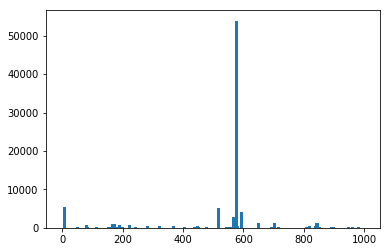

In [132]:
#plt.hist(actual_error_scores_test, alpha=0.5,color=['green'],bins=[0, 10, 50, 100,500,1000])#,5000,10000,50000,100000,200000])
#x= [i for i in range(1001)]
plt.bar(range(1000),actual_error_scores_test,10)




<Container object of 1000 artists>

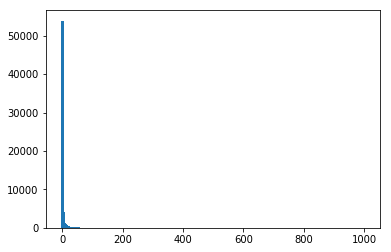

In [143]:
#sort and plot bar chartr
plt.bar(range(1000),sorted(actual_error_scores_test,reverse=True),10)

<Container object of 1000 artists>

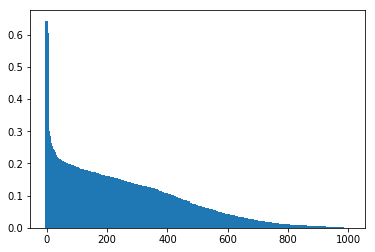

In [133]:
# scaled rmse test values
plt.bar(range(1000),sorted(test_rmse,reverse=True),10)

In [134]:
#bin the errors and find frequency of customers
#bin_test_error = pd.cut(actual_error_scores_test,
#                     bins=[0, 100, 500, 1000, 5000,10000,50000,100000,20000],
                     #labels=["0-100", "100-500", "500-1000", "1000-5000","5000-10000","10000-50000","50000-100000","100000-200000"])

                        
# Binning data 
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    
    bins = []
    for low in range(lower_bound,lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins


bins = create_bins(lower_bound=0,width=100,quantity=1000)
import pandas as pd
bins2 = pd.IntervalIndex.from_tuples(bins)
categorical_object = pd.cut(actual_error_scores_test, bins2)
print(categorical_object)
pd.value_counts(categorical_object)

[(0, 100], (0, 100], (0, 100], (0, 100], (0, 100], ..., (0, 100], (0, 100], (0, 100], (0, 100], (0, 100]]
Length: 1000
Categories (1001, interval[int64]): [(0, 100] < (100, 200] < (200, 300] < (300, 400] ... (99700, 99800] < (99800, 99900] < (99900, 100000] < (100000, 100100]]


(0, 100]          955
(100, 200]         14
(200, 300]          8
(400, 500]          4
(500, 600]          4
(1200, 1300]        3
(600, 700]          2
(300, 400]          1
(53900, 54000]      1
(700, 800]          1
(800, 900]          1
(4100, 4200]        1
(1100, 1200]        1
(2700, 2800]        1
(1300, 1400]        1
(5000, 5100]        1
(5400, 5500]        1
(33600, 33700]      0
(33700, 33800]      0
(33800, 33900]      0
(34200, 34300]      0
(33900, 34000]      0
(34000, 34100]      0
(34100, 34200]      0
(34300, 34400]      0
(34400, 34500]      0
(33500, 33600]      0
(32900, 33000]      0
(33400, 33500]      0
(33300, 33400]      0
                 ... 
(68600, 68700]      0
(65800, 65900]      0
(68500, 68600]      0
(68400, 68500]      0
(68300, 68400]      0
(68200, 68300]      0
(68100, 68200]      0
(68000, 68100]      0
(67900, 68000]      0
(67800, 67900]      0
(67700, 67800]      0
(67600, 67700]      0
(67500, 67600]      0
(67400, 67500]      0
(67300, 67

In [135]:
# bins on scaled rmse values
# since pd.cut doesn't accept float values
import numpy as np

#bins = create_bins(lower_bound=0,width=0.05,quantity=8)
bins = [0, 0.4]
hist, bin_edges = np.histogram(test_rmse, bins=bins)
hist, bin_edges = np.histogram(test_rmse, bins=8)
print (hist)
print (bin_edges)
df_binedges = pd.DataFrame()

#create dataframe with bin values
for i in range(len(hist)):
    df_binedges.at[i,'binedge_1'] = float(bin_edges[i])
    df_binedges.at[i,'binedge_2'] = float(bin_edges[i+1])
    df_binedges.at[i,'count'] = hist[i]

df_binedges



[530 275 173  18   2   0   0   2]
[2.78949738e-05 8.04655241e-02 1.60903153e-01 2.41340782e-01
 3.21778411e-01 4.02216040e-01 4.82653670e-01 5.63091299e-01
 6.43528928e-01]


,binedge_1,binedge_2,count
0,0.000028,0.080466,530.0
1,0.080466,0.160903,275.0
2,0.160903,0.241341,173.0
3,0.241341,0.321778,18.0
4,0.321778,0.402216,2.0
5,0.402216,0.482654,0.0
6,0.482654,0.563091,0.0
7,0.563091,0.643529,2.0


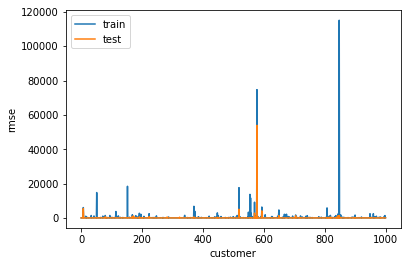

In [137]:
#actual rmse values
import matplotlib.pyplot as plt
plt.plot(actual_train_rmse,label ="train")
plt.plot(actual_error_scores_test,label = "test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

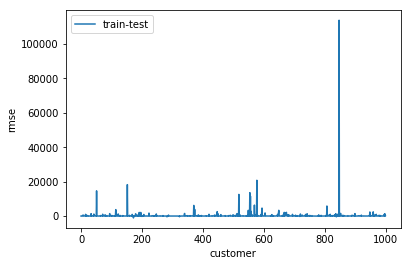

In [139]:
#actual rmse values
import operator
plt.plot(list(map(operator.sub, actual_train_rmse, actual_error_scores_test)),label = "train-test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

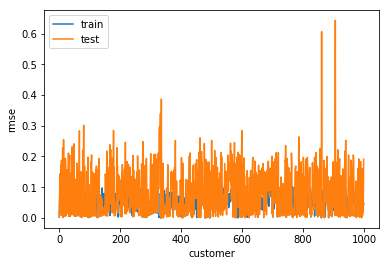

In [140]:
import matplotlib.pyplot as plt
plt.plot(train_rmse,label ="train")
plt.plot(test_rmse,label = "test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

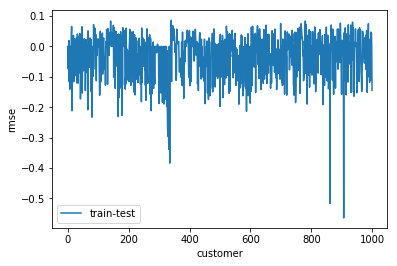

In [141]:
import operator
plt.plot(list(map(operator.sub, train_rmse, test_rmse)),label = "train-test")
plt.xlabel("customer")
plt.ylabel("rmse")
plt.legend()

7902786
count    800.000000
mean      -2.001022
std       51.374343
min     -515.153325
25%        0.000000
50%        0.000000
75%        0.000000
max      285.078518
Name: fv_cost, dtype: float64
test describe count    50.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: fv_cost, dtype: float64
[[20.72095747]]


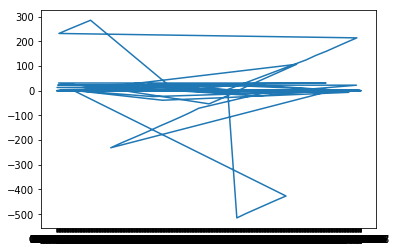

In [142]:
#find customers outstanding
# customer whose rmse value grater than 100000
#filter(lambda x : x.actual_error_scores_test > 100, cust)
cust = []
for i in range(len(actual_error_scores_test)):
    if (actual_error_scores_test[i] > 50000):
        cust.append(i)
        
cust

cust_id = df['client_debtor_number'].unique()
print (cust_id[cust[0]])

# graph
test_cust = df[df['client_debtor_number'] == cust_id[cust[0]]]
print (test_cust.fv_cost.describe())

list_x = test_cust[test_cust['dates'].str.contains('/2018') == True]
print ("test describe",list_x.fv_cost.describe())
plt.plot(test_cust['dates'],test_cust['fv_cost'])



In [108]:
# Clusters
import zipfile
with zipfile.ZipFile("customer_clusters.zip", 'r') as zip_ref:
    # printing all the contents of the zip file 
    zip_ref.printdir() 
  
    # extracting all the files 
    print('Extracting all the files') 
    zip_ref.extractall() 
    print('Done!') 

File Name                                             Modified             Size
timeseries_eight_clusters.csv                  2019-01-10 11:00:34      7695759
timeseries_features_three_clusters.csv         2019-01-10 10:55:06      7695759
timeseries_features_two_clusters.csv           2019-01-10 10:55:22      7695759
timeseries_fifteen_clusters.csv                2019-01-10 10:56:36      7696246
Extracting all the files now...
Done!
